In [11]:
from collections import deque
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go



In [12]:
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [13]:
class Environment:
 
  def __init__(self, data, window_size=90, initial_balance=10000):
    self.data = data
    self.window_size = window_size
    self.initial_balance = initial_balance
    self.reset()

  def reset(self):
    self.balance = self.initial_balance
    self.shares_held = 0
    self.cost_price = 0  # Track buying price for calculating ROI
    self.state = deque(maxlen=self.window_size)
    self.history = self.data.iloc[:self.window_size]  # Initial window of data
    self.current_step = self.window_size  # Start after initial window

    # Fill initial state with normalized prices
    for i in range(self.window_size):
      close_price = self.history.iloc[i]['Close']
      self.state.append((close_price - self.history.iloc[0]['Close']) / self.history.iloc[0]['Close'])

    return self._get_obs()

  def _get_obs(self):
    return np.array(self.state)

  def step(self, action):
    # Handle actions (0: hold, 1: buy, 2: sell)
    if action == 0:
      pass  # Hold
    elif action == 1:
      if self.balance >= self.data.iloc[self.current_step]['Close'] and self.shares_held == 0:
        self.balance -= self.data.iloc[self.current_step]['Close']
        self.shares_held = 1
        self.cost_price = self.data.iloc[self.current_step]['Close']  # Update cost price
    elif action == 2:
      if self.shares_held > 0:
        self.balance += self.shares_held * self.data.iloc[self.current_step]['Close']
        self.shares_held = 0
        self.cost_price = 0  # Reset cost price after selling

    # Update state and reward
    next_close_price = self.data.iloc[self.current_step]['Close']
    reward = 0
    if self.shares_held > 0:
      reward = (next_close_price - self.cost_price) / self.cost_price  # Calculate ROI as reward
    self.state.append((next_close_price - self.history.iloc[0]['Close']) / self.history.iloc[0]['Close'])  # Update state
    self.history = pd.concat([self.history, self.data.iloc[self.current_step].to_frame().T])
    self.current_step += 1

    done = self.current_step >= len(self.data)
    return self._get_obs(), reward, done

In [14]:
class QLearningAgent:
    def __init__(self, actions, epsilon=0.1, alpha=0.2, gamma=0.9):
        self.q_table = {}
        self.actions = actions
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.losses = []  # List to store loss per episode

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            if tuple(state) not in self.q_table:
                self.q_table[tuple(state)] = np.zeros(len(self.actions))
            action = self.actions[np.argmax(self.q_table[tuple(state)])]
        return action

    def update_q_table(self, state, action, reward, next_state):
        state_str = self.state_to_string(state)
        next_state_str = self.state_to_string(next_state)
    
        # Ensure both state and next_state are in the same format
        if state_str not in self.q_table:
            self.q_table[state_str] = np.zeros(len(self.actions))
        if next_state_str not in self.q_table:
            self.q_table[next_state_str] = np.zeros(len(self.actions))
    
        # Q-value update
        current_q_value = self.q_table[state_str][action]
        next_max_q_value = np.max(self.q_table[next_state_str])
        target_q_value = reward + self.gamma * next_max_q_value
        loss = 0.5 * (target_q_value - current_q_value)**2  # Compute loss
        self.losses.append(loss)  # Append loss to list
    
        # Update Q-value
        self.q_table[state_str][action] += self.alpha * (target_q_value - current_q_value)


    
    def state_to_string(self, state):
        return ','.join(map(str, state))

In [15]:
ticker_symbol = 'AAPL'
data = download_data(ticker_symbol, "2010-01-01", "2023-12-31")
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470741,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481928,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378823,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800


In [16]:
df = pd.DataFrame(data)

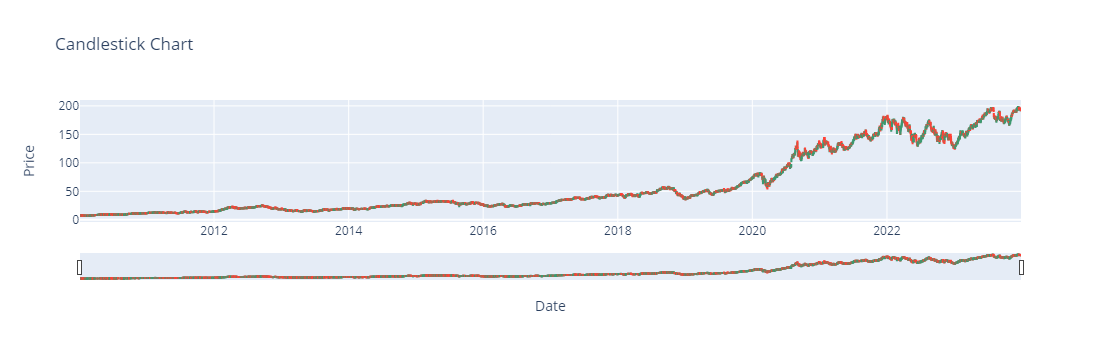

In [17]:
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
fig.update_layout(title='Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price')
fig.show()

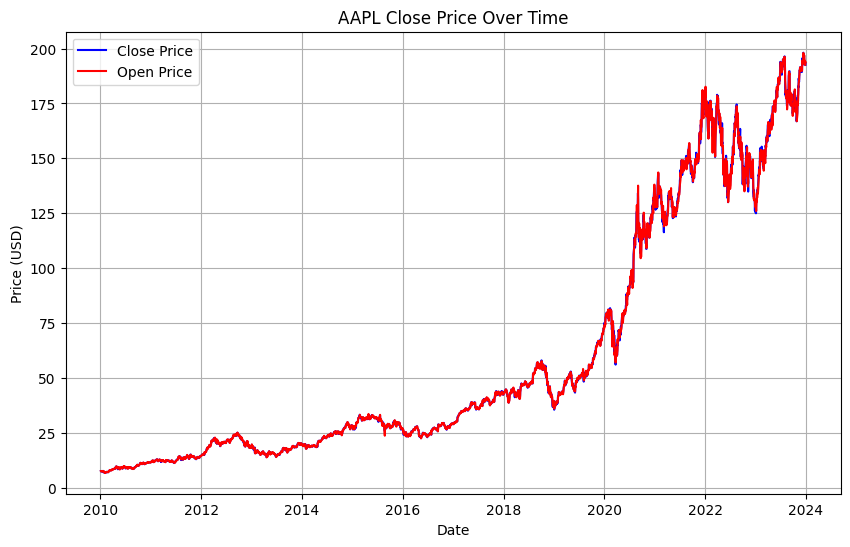

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.plot(data.index, data['Open'], label='Open Price', color='red')

plt.title(f'{ticker_symbol} Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Define hyperparameter grids
epsilon_values = [0.1, 0.2, 0.3]
alpha_values = [0.1, 0.2, 0.3]
gamma_values = [0.9, 0.95, 0.99]

In [21]:
window_size = 90
initial_balance = 10000
num_episodes = 1000
best_reward = float('-inf')
best_hyperparameters = {}

In [22]:
# Grid search
for epsilon in epsilon_values:
    for alpha in alpha_values:
        for gamma in gamma_values:
            actions = [0, 1, 2]
            env = Environment(data, window_size, initial_balance)
            agent = QLearningAgent(actions, epsilon, alpha, gamma)

            episode_rewards = []
            for episode in range(num_episodes):
                state = env.reset()
                done = False
                episode_reward = 0
                agent.losses = []

                while not done:
                    action = agent.choose_action(state)
                    next_state, reward, done = env.step(action)
                    episode_reward += reward
                    agent.update_q_table(state, action, reward, next_state)
                    state = next_state

                episode_rewards.append(episode_reward)

            mean_reward = np.mean(episode_rewards)

            if mean_reward > best_reward:
                best_reward = mean_reward
                best_hyperparameters = {'epsilon': epsilon, 'alpha': alpha, 'gamma': gamma}

            print(f"Epsilon: {epsilon}, Alpha: {alpha}, Gamma: {gamma}, Mean Reward: {mean_reward}")

print("Best Hyperparameters:", best_hyperparameters)



Epsilon: 0.1, Alpha: 0.1, Gamma: 0.9, Mean Reward: 52.25303675065836
Epsilon: 0.1, Alpha: 0.1, Gamma: 0.95, Mean Reward: 52.14205563135105
Epsilon: 0.1, Alpha: 0.1, Gamma: 0.99, Mean Reward: 52.88224600896628
Epsilon: 0.1, Alpha: 0.2, Gamma: 0.9, Mean Reward: 52.215298011430306
Epsilon: 0.1, Alpha: 0.2, Gamma: 0.95, Mean Reward: 51.0877260490953
Epsilon: 0.1, Alpha: 0.2, Gamma: 0.99, Mean Reward: 52.54375225476496
Epsilon: 0.1, Alpha: 0.3, Gamma: 0.9, Mean Reward: 51.81279211458116
Epsilon: 0.1, Alpha: 0.3, Gamma: 0.95, Mean Reward: 54.05942515240701
Epsilon: 0.1, Alpha: 0.3, Gamma: 0.99, Mean Reward: 52.62345056760334
Epsilon: 0.2, Alpha: 0.1, Gamma: 0.9, Mean Reward: 25.24678653037829
Epsilon: 0.2, Alpha: 0.1, Gamma: 0.95, Mean Reward: 25.625703093957853
Epsilon: 0.2, Alpha: 0.1, Gamma: 0.99, Mean Reward: 25.147235498407003
Epsilon: 0.2, Alpha: 0.2, Gamma: 0.9, Mean Reward: 25.305793512550043
Epsilon: 0.2, Alpha: 0.2, Gamma: 0.95, Mean Reward: 26.21869183405473
Epsilon: 0.2, Alpha: 0

In [19]:


# Define training parameters
window_size = 90
initial_balance = 10000
num_episodes = 1000
epsilon = 0.1 #best_hyperparameters['epsilon']
alpha = 0.3 #best_hyperparameters['alpha']
gamma = 0.95 #best_hyperparameters['gamma']

# Create environment and agent
actions = [0, 1, 2]  # 0: hold, 1: buy, 2: sell
env = Environment(data, window_size, initial_balance)
agent = QLearningAgent(actions, epsilon, alpha, gamma)



In [23]:
# Training loop
episode_rewards = [] 
episode_losses = [] 
for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    agent.losses = []
    
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        episode_reward += reward
        agent.update_q_table(state, action, reward, next_state)
        state = next_state
        
    episode_rewards.append(episode_reward)
    episode_losses.append(np.mean(agent.losses))
    print(f"Episode: {episode+1} | Total Reward: {episode_reward} | Loss: {np.mean(agent.losses)}")


Episode: 1 | Total Reward: 22.561905200275056 | Loss: 0.0007194386453824169
Episode: 2 | Total Reward: 14.203527040469211 | Loss: 0.0006609234806836262
Episode: 3 | Total Reward: -4.478662110231502 | Loss: 0.0006823804556482129
Episode: 4 | Total Reward: 26.162737067979428 | Loss: 0.0008813941201493175
Episode: 5 | Total Reward: 15.87851814195167 | Loss: 0.0007578555427887422
Episode: 6 | Total Reward: 25.247664275795678 | Loss: 0.0006812359354000951
Episode: 7 | Total Reward: 14.73198938365936 | Loss: 0.0007630967209709157
Episode: 8 | Total Reward: -0.9783369742934369 | Loss: 0.000512380757630552
Episode: 9 | Total Reward: 8.566077483960699 | Loss: 0.000942601518035517
Episode: 10 | Total Reward: 8.42385008658866 | Loss: 0.0006341473868825099
Episode: 11 | Total Reward: 5.83163642997976 | Loss: 0.0005859928186507992
Episode: 12 | Total Reward: 8.255313836538374 | Loss: 0.00047006247949047834
Episode: 13 | Total Reward: 3.1280308305270057 | Loss: 0.0007616303377295094
Episode: 14 | To

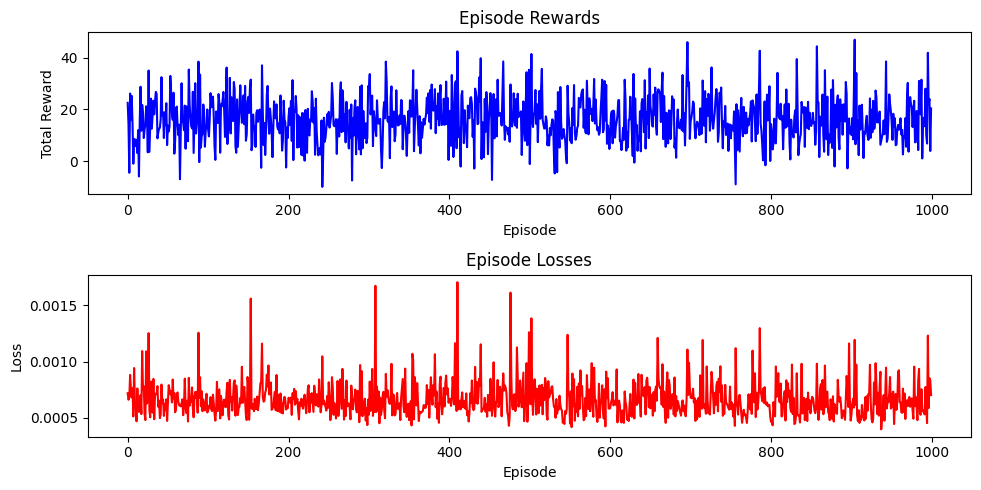

In [24]:

# Plotting episode rewards
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(range(len(episode_rewards)), episode_rewards, color='blue')
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# Plotting episode losses
plt.subplot(2, 1, 2)
plt.plot(range(len(episode_losses)), episode_losses, color='red')
plt.title('Episode Losses')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [ ]:
train_data = data.iloc[:int(len(data) * 0.8)]  # 80% for training
test_data = data.iloc[int(len(data) * 0.8):]   # 20% for testing

In [ ]:
# Training loop
for episode in range(num_episodes):
    state = env.reset(train_data)
    done = False
    episode_reward = 0
    agent.losses = []
    
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        episode_reward += reward
        agent.update_q_table(state, action, reward, next_state)
        state = next_state
        
    episode_rewards.append(episode_reward)
    episode_losses.append(np.mean(agent.losses))
    print(f"Training Episode: {episode+1} | Total Reward: {episode_reward} | Loss: {np.mean(agent.losses)}")
